In [38]:
import numpy as np
import glob
import sys
import time
import datetime
import os
import pickle

Utilities
---------

In [2]:
def printError(*arg):
    print('Error:', *arg, file=sys.stderr)
    
def printDebug(*arg):
    print('Debug:', *arg, file=sys.stderr)
    
def printWarning(*arg):
    print('Warning:', *arg, file=sys.stderr)

Hardware interface
------------------

In [10]:
class ElectronicsInterface:
    def __init__(self, gpio_pin=18, sensor=None):
        self.pin = gpio_pin
        self.sensor = None
        self.GPIO = None
        
        if sensor is None:
            temperature_sensors = glob.glob('/sys/bus/w1/devices/28-*/w1_slave')
            
            if len(temperature_sensors) > 1:
                printError('multiple temperature sensors found, please specify - entering fake mode')
                return
            elif len(temperature_sensors) == 0:
                printError('temperature sensor cannot be found - entering fake mode')
                return
            else:
                printDebug('temperature sensor found: ' + temperature_sensors[0])
                sensor = temperature_sensors[0]
        
        self.sensor = sensor
        
        try:
            self.read_temperature()
        except:
            printError('temperature sensor cannot be read - entering fake mode.')
            self.sensor = None
            return
        
        try:
            import RPi.GPIO as GPIO
            
            GPIO.setmode(GPIO.BCM)
            GPIO.setup(gpio_pin, GPIO.OUT, initial=GPIO.LOW)
            
            self.GPIO = GPIO
            
            printDebug('GPIO up and running')
        except:
            self.GPIO = None
            printError('GPIO not working - entering fake mode')
            
    def read_temperature(self):
        if self.sensor is not None:
            with open(self.sensor, 'r') as f:
                lines = f.readlines()
        else:
            lines = ['69 01 ff ff 7f ff ff ff 7e : crc=7e YES\n', '69 01 ff ff 7f ff ff ff 7e t=22562\n']
            
        if lines[0].strip()[-3:] == 'YES':
            self.temperature = int(lines[1].strip().split('=')[1]) / 1000
        else:
            self.temperature = np.nan
            printWarning('no temperature read')
            
        return self.temperature
    
    def write_relay(self, value):
        if self.GPIO is not None:
            self.GPIO.output(self.pin, value)
            
    def close(self):
        if self.GPIO is not None:
            self.GPIO.cleanup(self.pin)

In [9]:
interface = ElectronicsInterface()

Debug: temperature sensor found: /sys/bus/w1/devices/28-80000026d00e/w1_slave


In [13]:
interface.write_relay(False)

Let's collect some data!
------------------------

In [19]:
temperatures = []

In [20]:
relay_on = True

interface.write_relay(True)

# run for an hour max
for i in range(3600):
    temperature = interface.read_temperature()
    temperatures.append(temperature)
    print(temperature)
    
    if relay_on and temperature >= 50:
        interface.write_relay(False)
        relay_on = False
        
    if os.path.exists('/tmp/stop'):
        break
    
    time.sleep(1)
    
if relay_on:
    interface.write_relay(False)
    relay_on = False

22.437
22.375
22.437
22.437
22.375
22.375
22.437
22.437
22.437
22.437
22.437
22.375
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.375
22.437
22.437
22.437
22.437
22.437
22.437
22.375
22.375
22.437
22.375
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.375
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.437
22.5
22.437
22.5
22.5
22.5
22.562
22.5
22.562
22.562
22.562
22.562
22.625
22.625
22.625
22.687
22.687
22.75
22.812
22.812
22.875
22.875
22.875
22.937
22.937
22.937
23.0
23.0
23.0
23.0
23.062
23.125
23.125
23.125
23.187
23.187
23.187
23.25
23.312
23.312
23.312
23.375
23.437
23.5
23.562
23.625
23.687
23.75
23.812
23.812
23.875
23.875
23.875
23.875
23.937
23.937
23.937
23.937
24.0
24.0
24.062
24.062
24.062
24.062
24.125
24.125
24.187
24.187
24.25
24.312
24.312
24.375
24.375
24.437

In [23]:
interface.read_temperature()

48.125

In [24]:
import matplotlib.pyplot as plt

/usr/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [25]:
%matplotlib inline

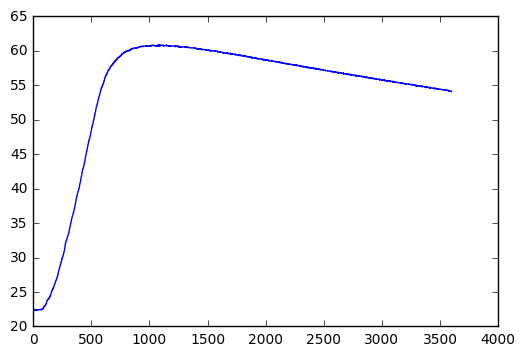

In [26]:
fig = plt.figure()
plt.plot(temperatures)

In [27]:
max(temperatures)

60.812

In [29]:
interface.read_temperature()

40.437

In [31]:
np.where(np.array(temperatures) > 50)[0][0]

522

In [32]:
c = 4.19
m = 1
dT = max(temperatures) - min(temperatures)
dQ = c * m * dT
P = 400
t = np.where(np.array(temperatures) > 50)[0][0]
E = P * t
nu = dQ / E
print('Wirkungsgrad:', nu)

Wirkungsgrad: 0.000771317193487


In [34]:
dQ

161.05103

In [35]:
dT

38.437

In [36]:
t

522

In [39]:
with open('temperature1.pkl', 'wb') as f:
    pickle.dump(np.array(temperatures), f)

In [41]:
with open('temperature1.csv', 'w') as f:
    for v in temperatures:
        f.write(str(v) + '\n')

In [40]:
interface.close()